<a href="https://colab.research.google.com/github/NayelySaldivar/DesafioData/blob/main/DataMexico_Unsupervised_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Desafío Data México </h2>
<h4> <p> Segunda Edición - Datos con perspectiva de género </p> </h4> 

##### Importación de librerías:

In [ ]:
import pandas as pd
import numpy as np
import requests
import plotly.express as px
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carga de Bases de Datos:

### - Resultados Covid desde la plataforma **DataMexico**:

- Utilizamos la **DataMexico API Explorer** para obtener los datos actualizados:

In [ ]:
data=requests.get('https://api.datamexico.org/tesseract/cubes/gobmx_covid/aggregate.jsonrecords?drilldowns%5B%5D=Death+Date.Death+Date.Death+Date&drilldowns%5B%5D=Covid+Result.Covid+Result.Covid+Result&drilldowns%5B%5D=Health+Institution+Attended.Health+Institution+Attended.Health+Institution+Attended&drilldowns%5B%5D=Pneumonia+Diagnose.Pneumonia+Diagnose.Pneumonia+Diagnose&drilldowns%5B%5D=COPD+Diagnose.COPD+Diagnose.COPD+Diagnose&drilldowns%5B%5D=Asthma+Diagnose.Asthma+Diagnose.Asthma+Diagnose&drilldowns%5B%5D=Inmunosupresion+Diagnose.Inmunosupresion+Diagnose.Inmunosupresion+Diagnose&drilldowns%5B%5D=Hypertension+Diagnose.Hypertension+Diagnose.Hypertension+Diagnose&drilldowns%5B%5D=Cardiovascular+Diagnose.Cardiovascular+Diagnose.Cardiovascular+Diagnose&drilldowns%5B%5D=Obesity+Diagnose.Obesity+Diagnose.Obesity+Diagnose&drilldowns%5B%5D=Chronic+Kidney+Failure+Diagnose.Chronic+Kidney+Failure+Diagnose.Chronic+Kidney+Failure+Diagnose&drilldowns%5B%5D=Diabetes+Diagnose.Diabetes+Diagnose.Diabetes+Diagnose&drilldowns%5B%5D=State+Patient+Attended.State+Patient+Attended.State+Patient+Attended&drilldowns%5B%5D=State+Patient+Origin.State+Patient+Origin.State+Patient+Origin&drilldowns%5B%5D=Sex.Sex.Sex&drilldowns%5B%5D=Age+Group.Age+Group.Age&drilldowns%5B%5D=Municipality+Patient+Residence.Geography.Municipality&measures%5B%5D=Cases&parents=false&sparse=false')
data_api=pd.DataFrame(data.json()["data"])
data_api.shape

(265294, 34)

### - Datos históricos de **Mortalidad en Mujeres 2012-2019** del INEGI:

In [ ]:
mortalidad_mujeres=pd.read_csv(f'/content/drive/MyDrive/DesafioData/Bases_INEGI_Mujeres.csv')
mortalidad_mujeres.shape

(2272081, 22)

## Preparación de la información para construir el modelo

In [ ]:
!pip install feature_engine

### Tabulados de Mortalidad **INEGI**

Debido a la cantidad de datos y los recursos con los que contamos, decidimos tomar el último quiquenio que tenemos registrado en el histórico de muertes para crear nuestro modelo de ML:

In [ ]:
data_mujeres_quinquenio = mortalidad_mujeres[mortalidad_mujeres['date'].isin([2015,2016,2017,2018,2019])].reset_index(drop=True)

Volvemos dummies las variables de los grupos de enfermedad y el tipo de institución en donde se realizó el registro:

In [ ]:
data_mujeres=data_mujeres_quinquenio['gpo_enfermedad']
data_institucion=data_mujeres_quinquenio['derechohab']

dum_df = pd.get_dummies(data_mujeres, columns=['gpo_enfermedad'], prefix="Gpo_Enfermedad_is")
dum_ins = pd.get_dummies(data_institucion, columns=['derechohab'], prefix="Institucion_is")

Añadimos las variables que coinciden con la base de COVID:

In [ ]:
data_mujeres=pd.concat([dum_df,data_mujeres_quinquenio[['sexo','edad_real']],dum_ins,data_mujeres_quinquenio['ent_regis']],axis=1)

Eliminamos los registros que queden fuera de nuestros grupos de enfermedad:

In [ ]:
data_mujeres_limpia=data_mujeres.copy()

print(f'Shape Inicial: {data_mujeres_limpia.shape}')

rows_to_drop=data_mujeres[data_mujeres['Gpo_Enfermedad_is_otros']==1].index
data_mujeres_limpia=data_mujeres_limpia.drop(rows_to_drop,axis=0).reset_index(drop=True)

rows_to_drop=data_mujeres_limpia[data_mujeres_limpia['Institucion_is_99']==1].index
data_mujeres_limpia=data_mujeres_limpia.drop(rows_to_drop,axis=0).reset_index(drop=True)

rows_to_drop=data_mujeres_limpia[data_mujeres_limpia['edad_real']==998].index
data_mujeres_limpia=data_mujeres_limpia.drop(rows_to_drop,axis=0).reset_index(drop=True)

data_mujeres_limpia=data_mujeres_limpia.drop(['Gpo_Enfermedad_is_otros','Institucion_is_99'],axis=1)

print(f'Shape Inicial: {data_mujeres_limpia.shape}')

Shape Inicial: (1488372, 23)
Shape Inicial: (897121, 21)


### Datos **Covid-19** API Data México

Encoding del tipo de institución en el que se atendió el fallecido

In [ ]:
data_api['Health Institution Attended']=np.where(
    data_api['Health Institution Attended']=='IMSS',2,np.where(
    data_api['Health Institution Attended']=='ISSSTE',3,np.where(
    data_api['Health Institution Attended']=='PEMEX',4,np.where(
    data_api['Health Institution Attended']=='SEDENA',5,np.where(
    data_api['Health Institution Attended']=='SEMAR',6,np.where(
    data_api['Health Institution Attended']=='IMSS-Bienestar',7,8    
    )    
    )
    )    
    )    
    )
    )

Homologamos los valores dummies de la base:

In [ ]:
enfermedades=['Pneumonia Diagnose ID','COPD Diagnose ID','Asthma Diagnose ID','Inmunosupresion Diagnose ID','Hypertension Diagnose ID','Cardiovascular Diagnose ID','Obesity Diagnose ID','Chronic Kidney Failure Diagnose ID','Diabetes Diagnose ID']

for enf in enfermedades:
  data_api[enf]=np.where(data_api[enf]==1,1,0)

data_institucion=data_api['Health Institution Attended']
dum_df = pd.get_dummies(data_institucion, columns=['Health Institution Attended'], prefix="Institucion_is")

aux=pd.Series(0,index=range(len(data_api)))
dum_ins=pd.concat([aux,dum_df,aux],axis=1)
dum_ins.shape

(265294, 9)

Orden de las columnas

In [ ]:
# columnas_ml=['EPOC','Asma','Cardiovascular','Diabetes','Hipertension','Inmunosupresion','Inf_Renal','Neumonia','Obesidad','Sexo','Edad','Institucion','Estado','Municipio']
data_api_ml_completo=pd.concat([data_api[['COPD Diagnose ID','Asthma Diagnose ID','Cardiovascular Diagnose ID','Diabetes Diagnose ID','Hypertension Diagnose ID','Inmunosupresion Diagnose ID','Chronic Kidney Failure Diagnose ID','Pneumonia Diagnose ID','Obesity Diagnose ID','Sex ID','Age']],dum_ins,data_api['State Patient Attended ID']],axis=1)
data_api_ml_completo.shape

(265294, 21)

In [ ]:
data_api_ml_completo.Age.unique()

array([ 65,  15,  67,  32,  47,  46,  56,   1,  84,  82,  12,   3,  58,
        41,  48,  68,  79,  52,  76,  72,  21,  98,  62,  42,   6,  44,
        49,  81,  50,  38,  77,  88,  61,  64,  74,  34,  75,  92,  59,
        94,  87,  60,  63,  35,  70,  45,  66,  73,  69,  51,  78,  80,
        57,   7,  91,  26,  54,  53,  85,  93, 100,  71,  55,  99,  33,
        83,  30,  25,  40,  37,  36,  86,  43,  31,  13,   5,   2,   4,
        11,  95,  39,  89,  27,  16,  96,  22,  28,  29,  20,  90,  18,
         0,  23,  10,   8, 103,  24,  17,  19,  14,   9,  97, 101, 119,
       109, 102, 108, 110, 106, 104, 105, 116])

Eliminamos los registros en los que desconoce la edad del fallecido:

In [ ]:
print(f'Shape Inicial: {data_api_ml_completo.shape}')

rows_to_drop=data_api_ml_completo[data_api_ml_completo['Age']==998].index
data_api_ml_completo=data_api_ml_completo.drop(rows_to_drop,axis=0).reset_index(drop=True)

print(f'Shape Inicial: {data_api_ml_completo.shape}')

Shape Inicial: (265294, 21)
Shape Inicial: (265294, 21)


## Unificación de variables

Tenemos nuestras bases completas, ahora hay que homologar el nombre de las columnas:

In [ ]:
data_inegi_ml=data_mujeres_limpia.copy().drop('sexo',axis=1)
data_api_ml=data_api_ml_completo[data_api_ml_completo['Sex ID']==2].drop('Sex ID',axis=1).reset_index(drop=True)

columnas_ml=['EPOC','Asma','Cardiovascular','Diabetes','Hipertension','Inmunosupresion','Inf_Renal','Neumonia','Obesidad','Edad',\
             'Ninguno','IMSS','ISSSTE','PEMEX','SEDENA','SEMAR','Popular/Bienestar','Otro','Prospera','Estado']

data_inegi_ml.columns=columnas_ml
data_api_ml.columns=columnas_ml

Salvamos los csv para el desarrollo final:

In [ ]:
data_inegi_ml.to_csv('Base_INEGI_ML.csv')
data_api_ml.to_csv('Base_Covid_ML.csv')
data_ml=pd.concat([data_inegi_ml,data_api_ml],axis=0).reset_index(drop=True)
data_ml.to_csv('BaseCompleta_ML.csv',index_label=False)
print(data_ml.shape)
data_ml.head()

(997306, 20)


,EPOC,Asma,Cardiovascular,Diabetes,Hipertension,Inmunosupresion,Inf_Renal,Neumonia,Obesidad,Edad,Ninguno,IMSS,ISSSTE,PEMEX,SEDENA,SEMAR,Popular/Bienestar,Otro,Prospera,Estado
0,0,0,0,1,0,0,0,0,0,67,1,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,74,0,0,0,0,0,0,1,0,0,1
2,0,0,1,0,0,0,0,0,0,70,0,0,1,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,4,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,56,0,1,0,0,0,0,0,0,0,1


In [ ]:
# data_inegi_ml=pd.read_csv('Base_INEGI_ML.csv')
# data_api_ml=pd.read_csv('Base_Covid_ML.csv')
# data_ml=pd.read_csv('BaseCompleta_ML.csv')

## Unsupervised ML - Clusterización 

**Nota:** Realizamos varios modelos en función de representar puntualmente las divisiones, decidimos mantener el de KMeans para la presentación final.

### K Means

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Con ayuda el elbow method buscamos el número de clusters óptimo para la partición:

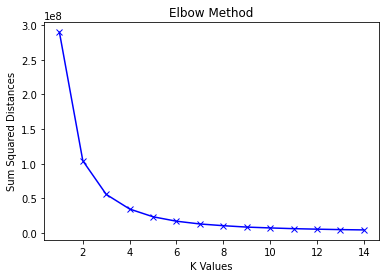

In [ ]:
K = range(1,15)
sum_squared_distances = []
for k in K:
  # model = KMeans(n_clusters=k).fit(data_api_ml.drop('Estado',axis=1))
  model = KMeans(n_clusters=k).fit(data_ml.drop('Estado',axis=1))
  sum_squared_distances.append(model.inertia_)
plt.plot(K, sum_squared_distances, "bx-")
plt.xlabel("K Values")
plt.ylabel("Sum Squared Distances")
plt.title("Elbow Method")
plt.show()

Identificamos 4 clusters

In [ ]:
kmeans = KMeans(n_clusters=4)
data_api_clusters = kmeans.fit(data_ml.drop(['Estado'],axis=1))
preds = data_api_clusters.fit_predict(data_ml.drop(['Estado'],axis=1))

Marcamos cada cluster en la base con la columna **cluster**:

In [ ]:
data_ml['Cluster_KMeans']=preds
data_ml.head(2)

,EPOC,Asma,Cardiovascular,Diabetes,Hipertension,Inmunosupresion,Inf_Renal,Neumonia,Obesidad,Edad,Ninguno,IMSS,ISSSTE,PEMEX,SEDENA,SEMAR,Popular/Bienestar,Otro,Prospera,Estado,Cluster_KMeans
0,0,0,0,1,0,0,0,0,0,67,1,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,74,0,0,0,0,0,0,1,0,0,1,0


In [ ]:
data_ml.to_csv('Cluster_KMeans.csv')

In [ ]:
# data_api_ml[data_api_ml.Cluster==0].Estado.value_counts()
# silhouette_score(data_ml,kmeans.labels_,metric='euclidean',sample_size=len(data_ml))

### DBSCAN

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

Con ayuda de NN identificamos la distancia óptima

In [ ]:
# nearest_neighbors = NearestNeighbors(n_neighbors=1000)
# nearest_neighbors.fit(data_api_ml.drop('Estado',axis=1))
# distances, indices = nearest_neighbors.kneighbors(data_api_ml.drop('Estado',axis=1))
# distances = np.sort(distances, axis=0)[:,1]
# plt.figure(figsize=(10,6))
# plt.plot(distances)
# plt.show()

Creamos el modelo:

In [ ]:
m = DBSCAN(eps=200,min_samples=40)
m

DBSCAN(algorithm='auto', eps=200, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=40, n_jobs=None, p=None)

In [ ]:
# m.fit(data_api_ml.drop('Estado',axis=1))
m.fit(data_ml.drop('Estado',axis=1))

Creamos los cluster y etiquetamos el ruido.

In [ ]:
#Asignar nuestros labels/clusters
labels = m.labels_

#Empezar a enmascarar nuestros datos
labels_mask_general = np.zeros_like(labels,dtype=bool)

#Colocar outliers como verdadero
labels_mask_general[m.core_sample_indices_] = True

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Número de clusters: {n_clusters}')
print(f'Registros con ruido: {n_noise}')

Número de clusters: 10
Registros con ruido: 970


In [ ]:
# Estandarizado
m.fit(standardized_data)

In [ ]:
#Asignar nuestros labels/clusters
labels = m.labels_

#Empezar a enmascarar nuestros datos
labels_mask_general = np.zeros_like(labels,dtype=bool)

#Colocar outliers como verdadero
labels_mask_general[m.core_sample_indices_] = True

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Número de clusters: {n_clusters}')
print(f'Registros con ruido: {n_noise}')

Creamos los cluster y etiquetamos el ruido.

In [ ]:
data_api_ml['Cluster_DBSCAN10']=labels

### HDBSCAN

In [ ]:
pip install hdbscan

In [ ]:
import sklearn.cluster as cluster
import scipy.cluster.hierarchy as sch
import hdbscan
from random import sample 
import matplotlib.pyplot as plt

Para la visualización del dendograma y visualizar los parámetros de clusterización tomaremos una muestra aleatoria de los datos:

In [ ]:
muestra_hdbscan=data_api_ml.drop(['Estado','Cluster_DBSCAN10'],axis=1).sample(frac=.1)

dendogram = sch.dendrogram(sch.linkage(muestra_hdbscan,method='ward'))

plt.title('Dendogram')
plt.xlabel('Customers')
plt.ylabel('Distancia Euclidiana')
plt.show()

Tomando la distancia vertical más larga y contando las veces que cruza con otras ramos, obtenemos que el tamaño minimo de los clusters debe ser de . 
Ejecutamos el modelo con esos parámetros:

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=200, gen_min_span_tree=True)

In [ ]:
# clusterer.fit(data_api_ml.drop(['Estado','Cluster_DBSCAN10'],axis=1))
clusterer.fit(data_ml.drop(['Estado','Ninguno','IMSS','ISSSTE','PEMEX','SEDENA','SEMAR','Popular/Bienestar','Otro','Prospera'],axis=1))

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=200, min_samples=None, p=None,
        prediction_data=False)

In [ ]:
# Asignar nuestros labels/clusters
labels = clusterer.labels_

# Empezar a enmascarar nuestros datos
labels_mask_general = np.zeros_like(labels,dtype=bool)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Número de clusters: {n_clusters}')
print(f'Registros con ruido: {n_noise}')

Número de clusters: 550
Registros con ruido: 58282


Asignamos los labels obtenidos:

In [ ]:
data_ml['Cluster_HDBSCAN_200']=labels
data_ml.head(2)

,EPOC,Asma,Cardiovascular,Diabetes,Hipertension,Inmunosupresion,Inf_Renal,Neumonia,Obesidad,Edad,Ninguno,IMSS,ISSSTE,PEMEX,SEDENA,SEMAR,Popular/Bienestar,Otro,Prospera,Estado,Cluster_HDBSCAN_200
0,0,0,0,1,0,0,0,0,0,67,1,0,0,0,0,0,0,0,0,1,235
1,0,0,0,1,0,0,0,0,0,74,0,0,0,0,0,0,1,0,0,1,256


In [ ]:
data_api_ml['Cluster_HDBSCAN'].value_counts()

 3    95739
-1     4128
 1        7
 2        6
 0        6
Name: Cluster_HDBSCAN, dtype: int64

### GMM

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.pyplot import figure

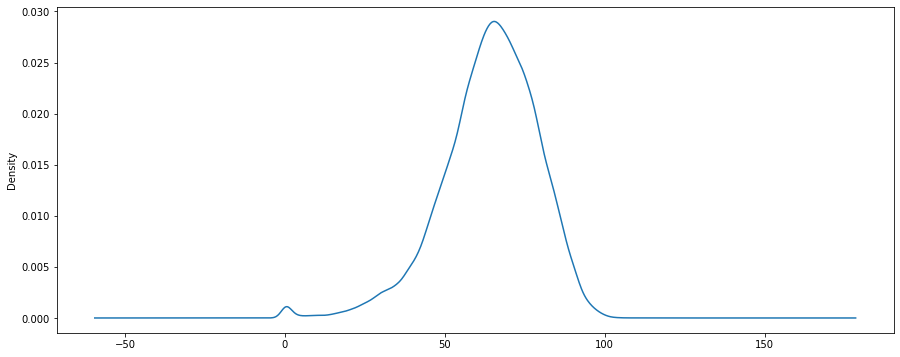

In [ ]:
figure(figsize=(15,6))
data_api_ml.Edad.plot(kind='kde');

Para obtener el número de componentes, obtenemos el valor de las 4 covarianzas.

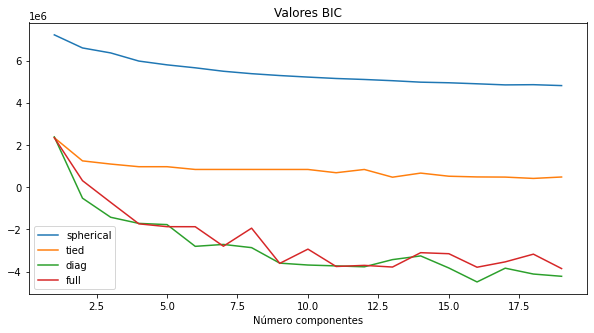

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

n_components = range(1, 20)
covariance_types = ['spherical', 'tied', 'diag', 'full']

for covariance_type in covariance_types:
    valores_bic = []
    
    for i in n_components:
        modelo = GMM(n_components=i, covariance_type=covariance_type)
        modelo = modelo.fit(data_api_ml.drop('Cluster_KMeans',axis=1))
        valores_bic.append(modelo.bic(data_api_ml.drop('Cluster_KMeans',axis=1)))
        # modelo = modelo.fit(data_api_ml.drop(['Cluster','Cluster_DBSCAN','Cluster_HDBSCAN'],axis=1))
        # valores_bic.append(modelo.bic(data_api_ml.drop(['Cluster','Cluster_DBSCAN','Cluster_HDBSCAN'],axis=1)))
        
    ax.plot(n_components, valores_bic, label=covariance_type)
ax.set_title("Valores BIC")
ax.set_xlabel("Número componentes")
ax.legend();

Corremos el modelo con el número de componentes = 13. 

In [ ]:
gm  = GMM(n_components=13, covariance_type='full')
gm.fit(data_api_ml.drop('Cluster_KMeans',axis=1))
# gm.fit(data_api_ml.drop(['Cluster','Cluster_DBSCAN','Cluster_HDBSCAN'],axis=1))

labels = gm.predict(data_api_ml.drop('Cluster_KMeans',axis=1))
# labels = gm.predict(data_api_ml.drop(['Cluster','Cluster_DBSCAN','Cluster_HDBSCAN'],axis=1))
data_api_ml['Cluster_GMM']= labels
data_api_ml.head(2)

,EPOC,Asma,Cardiovascular,Diabetes,Hipertension,Inmunosupresion,Inf_Renal,Neumonia,Obesidad,Edad,Institucion,Estado,Cluster_KMeans,Cluster_GMM
0,0,0,0,0,0,1,0,0,0,65,2,9,2,7
1,0,0,0,1,0,0,0,0,1,67,2,5,2,3


In [ ]:
data_ml.to_csv('Cluster_Covid_200.csv')